
# Image-to-Image Translation for Subsurface Reservoir Characterization

This project implements a Conditional Generative Adversarial Network (cGAN) to perform image-to-image translation for subsurface reservoir characterization. The model predicts properties such as porosity, permeability, and water saturation from input facies images, adapting the architecture and principles of the original Pix2Pix cGAN.

Pix2Pix is a versatile GAN model designed for general-purpose image-to-image translation tasks. It was introduced by Phillip Isola et al. in their 2016 paper, ["Image-to-Image Translation with Conditional Adversarial Networks"](https://arxiv.org/abs/1611.07004), which was later presented at CVPR in 2017. You can find more details about the original approach on the [Pix2Pix project page](https://phillipi.github.io/pix2pix/).

While the original Pix2Pix was demonstrated on tasks such as generating building facades, colorizing images, and transforming sketches into photos, this project tailors it specifically for geological datasets, enhancing the model's applicability to subsurface reservoir characterization.

## Tasks Addressed
1. **Property Mask Prediction**  
   - The model takes masked input images for each property (e.g., porosity, permeability, water saturation) and predicts their corresponding detailed outputs.
2. **Image-to-Image Translation**  
   - The model performs direct image translation from facies images to predicted properties such as porosity, permeability, or water saturation.

## Network Architecture
- **Generator**: A U-Net-based architecture to produce property maps (e.g., porosity, permeability) from facies images.
- **Discriminator**: A convolutional PatchGAN classifier to determine whether the generated property maps are realistic.

- **Architecture of the GeoPix Framework**  
  ![Pix2Pix GAN Architecture](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Figuers/Pix2Pix%20GAN%20rchitecture.png)
  
  
- **High-level architecture of the proposed GeoPix framework for subsurface reservoir characterization**  
  ![GeoPix Figure 1](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Figuers/GeoPix_Figure%201.png)



## Load Required Libraries

In [46]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

### Dataset loading

The dataset required for this project is hosted on [Zenodo](https://zenodo.org/uploads/14585437). It is organized into two main tasks for subsurface reservoir characterization. Each task contains multiple properties and their respective files.

---

#### **Task 1: Mask Input Prediction**
This task involves predicting reservoir properties using facies masks as inputs. The dataset for Task 1 includes the following:

- **Facies Masks**: 22.2 GB  
- **Porosity**: 20.6 GB  
- **Permeability**: 30.7 GB  
- **Water Saturation (Sw)**: 5 GB  

You can download the dataset for Task 1 from the [Zenodo dataset link](https://zenodo.org/uploads/14585437).

---

#### **Task 2: Image-to-Image Translation**
This task involves translating facies masks into property maps or vice versa. The dataset for Task 2 includes the following splits:

- **Pors.vs.Fc_dataset_split**: 39.5 GB  
- **Fc.vs.Pors_dataset_split**: 39.5 GB  
- **Perm vs Fc_dataset_split**: 49.2 GB  
- **Sw vs Fc_dataset_split**: 22.8 GB  

You can download the dataset for Task 2 from the same [Zenodo dataset link](https://zenodo.org/uploads/14585437). The dataset is organized into training, validation, and test splits for each property mapping.

---

#### Example Usage in Colab
```python
# Download and unzip the dataset
!wget -c https://zenodo.org/uploads/14585437 -O dataset.zip
!unzip dataset.zip


In [3]:
import zipfile
import pathlib

# Specify the name of the dataset for processing
dataset_name = 'Sw vs Fc_dataset_split'

# Provide the path to the dataset's compressed zip file
local_zip_path = '/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/Sw vs Fc_dataset_split.zip'

# Unzip the dataset into the target directory
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(path=pathlib.Path('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/'))

# Create the full path to the extracted dataset for easy access in later stages
PATH = pathlib.Path('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/') / dataset_name

# Log the path to confirm successful extraction
print(f"Dataset successfully extracted to: {PATH}")


Dataset successfully extracted to: /home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/Sw vs Fc_dataset_split


In [7]:
list(PATH.parent.iterdir())

[PosixPath('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/results'),
 PosixPath('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/Aug_Sw vs Fc'),
 PosixPath('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/Sw vs Fc_dataset_split.zip'),
 PosixPath('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/org_fc vs por'),
 PosixPath('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/Sw vs Fc_dataset_split'),
 PosixPath('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/all_Sw vs Fc_dataset_split.zip'),
 PosixPath('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/Aug_fc vs por'),
 PosixPath('/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/training_

Purpose: Verify the directory structure and confirm the presence of subdirectories (train/, test/, etc.).

In [5]:
sample_image = tf.io.read_file(str(PATH / 'train/1.png'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

W0000 00:00:1735759630.961650  270410 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(4184, 10080, 3)


Note: Confirms each image is 256 x 512 and contains two 256 x 256 sections.

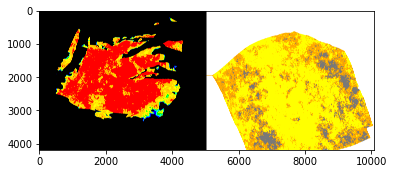

In [6]:
plt.figure()
plt.imshow(sample_image)

Purpose: Separates each image into:

    - Input (right half): Features like facies masks.
    - Output (left half): Ground truth properties (e.g., porosity, permeability)

In [7]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

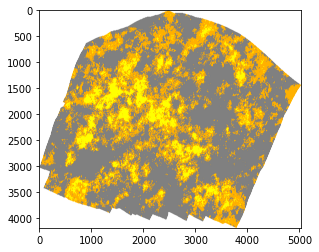

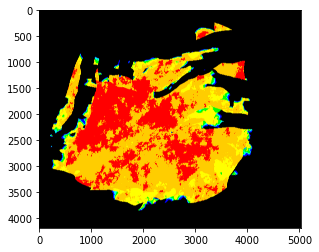

In [8]:
inp, re = load(str(PATH / 'train/100.png'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)



To improve model generalization and robustness, we preprocess the dataset using the following techniques inspired by the Pix2Pix methodology:

1. **Resize**: Each image is scaled from its original size (`256 x 256`) to a larger size (`286 x 286`) to allow for more effective cropping.
2. **Random Crop**: Images are cropped back to the original size (`256 x 256`) to introduce variability and simulate different framing.
3. **Random Horizontal Flip**: Images are randomly mirrored horizontally to further diversify the dataset.
4. **Normalization**: Pixel values are scaled to the range `[-1, 1]` to standardize inputs and enhance training stability.


In [10]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-NSet in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [12]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [13]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

You can inspect some of the preprocessed output:

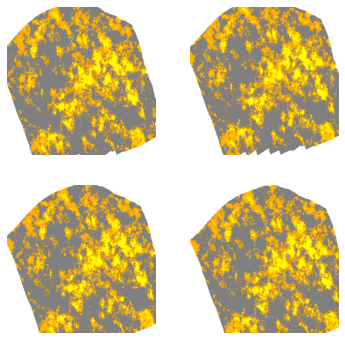

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [16]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [17]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## Building an Input Pipeline with `tf.data`

To efficiently load and preprocess the dataset for training and evaluation, we utilize TensorFlow's `tf.data` API. This approach ensures scalable and optimized data handling, even for large datasets.

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.png'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.png'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Constructing the Generator

The generator in this project is based on a _modified_ [U-Net](https://arxiv.org/abs/1505.04597) architecture. The U-Net design is particularly effective for tasks like image-to-image translation, as it integrates feature extraction with precise spatial information retention through skip connections.

---

### Key Components of the Architecture

- **Encoder (Downsampling Path)**:
  - Responsible for feature extraction and spatial dimension reduction.
  - Each block consists of: **Convolution → Batch Normalization → Leaky ReLU Activation**.

- **Decoder (Upsampling Path)**:
  - Reconstructs the spatial dimensions and refines the feature maps to produce the desired output.
  - Each block includes: **Transposed Convolution → Batch Normalization → Dropout (in the first 3 blocks) → ReLU Activation**.

- **Skip Connections**:
  - Directly connect corresponding layers from the encoder to the decoder.
  - These connections help retain important spatial details and improve the quality of the generated output.

---

### Advantages of the Modified U-Net

1. **Retains Fine Details**:
   - Skip connections ensure that critical spatial information from the input is not lost during feature extraction, enhancing accuracy in property predictions.

2. **Effective Feature Representation**:
   - The encoder extracts hierarchical features, capturing both local and global patterns crucial for subsurface property mapping.

3. **Accurate Reconstruction**:
   - The decoder, supported by skip connections, reconstructs high-quality property maps while preserving structural integrity.

4. **Specialized for Geological Data**:
   - This adaptation of U-Net has been optimized for subsurface reservoir characterization, making it suitable for properties like porosity, permeability, and water saturation.

---

In the following sections, we will dive deeper into the implementation of the generator's components, including the encoding, decoding, and skip connection mechanisms.


- **Schematic of the U-Net Generator and PatchGAN Discriminator for Facies-to-Property Translation**  
  ![G&D Schematic Diagram](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Figuers/G&D_schematic%20diagram.png)

Define the downsampler (encoder):

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 2092, 2520, 3)


Define the upsampler (decoder):

In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

2025-01-01 22:39:04.864613: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1012193280 exceeds 10% of free system memory.


(1, 4184, 5040, 3)


Assemble the Generator

The generator combines the downsampler and upsampler with skip connections to create a U-Net architecture.

    Downsampler Blocks: Extract hierarchical features.
    Upsampler Blocks: Reconstruct the image while maintaining fine details.
    Output Layer: Generates the final prediction with tanh activation for pixel intensity normalization.

In [25]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Generate a visual representation of the generator architecture:


In [26]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=300)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Test the generator on a resized input and visualize the output:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


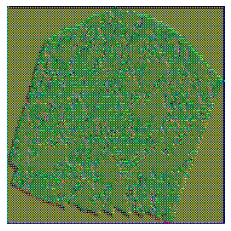

In [27]:

# Resize the input image to (256, 256)
inp_resized = tf.image.resize(inp, [256, 256])

# Add a batch dimension
inp_resized = inp_resized[tf.newaxis, ...]

# Test the generator with the resized input
gen_output = generator(inp_resized, training=False)

# Visualize the output
plt.imshow(gen_output[0, ...])
plt.axis('off')  # Hide axes
plt.show()

### Define Generator Loss

The generator loss ensures the generated output is both realistic and structurally similar to the target image. It consists of two components:

- **GAN Loss (Sigmoid Cross-Entropy Loss)**: Measures how well the generator fools the discriminator by comparing its output to an array of ones.
- **L1 Loss (Mean Absolute Error)**: Penalizes the structural difference between the generated and target images.

The total generator loss formula is:

Total Generator Loss = GAN Loss + λ × L1 Loss

where `λ = 100`.

---


In [28]:
LAMBDA = 100

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator and discrminator is as follows:

- **Training Procedure of the GeoPix Framework (adopted from Isola et al., 2017)**  
  ![G_D Training Procedures](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Figuers/G_D_Training_Procedures.png)



### Define Discriminator

The discriminator acts as a PatchGAN classifier, evaluating whether each patch of the image is real or fake. It compares two inputs:

1. **Input Image + Target Image (Real Pair)**: Assesses real data.
2. **Input Image + Generated Image (Fake Pair)**: Assesses generated data.

#### Key Components:
- **Architecture**: Each layer follows: Convolution → Batch Normalization → Leaky ReLU.
- **Output**: Each 30x30 patch evaluates a 70x70 portion of the input image.

---

Let's define the discriminator:

In [31]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

### Visualize Discriminator Output

To evaluate the discriminator's predictions, generate a heatmap visualization of its output. This step ensures the discriminator effectively distinguishes between real and generated images.

---

In [32]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=300)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Test the discriminator:

Input shape: (1, 256, 256, 3)
Generated output shape: (1, 256, 256, 3)


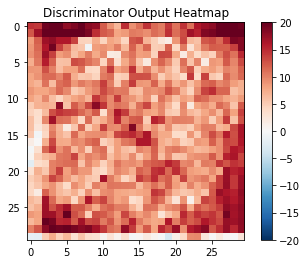

In [33]:
# Ensure inp and gen_output are of shape (256, 256, 3) before adding a batch dimension
inp_resized = tf.image.resize(inp, [256, 256])
gen_output_resized = tf.image.resize(gen_output, [256, 256])

# If necessary, add a single batch dimension if the tensors are not already batched
if len(inp_resized.shape) == 3:
    inp_resized = inp_resized[tf.newaxis, ...]
if len(gen_output_resized.shape) == 3:
    gen_output_resized = gen_output_resized[tf.newaxis, ...]

# Confirm shapes to avoid further issues
print("Input shape:", inp_resized.shape)  # Should be (1, 256, 256, 3)
print("Generated output shape:", gen_output_resized.shape)  # Should be (1, 256, 256, 3)

# Test the discriminator with the corrected inputs
disc_out = discriminator([inp_resized, gen_output_resized], training=False)

# Visualize the discriminator output
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.title("Discriminator Output Heatmap")
plt.show()


### Define the Discriminator Loss

The `discriminator_loss` function calculates how well the discriminator is able to distinguish real images from generated (fake) images.

- **Inputs**:
  - **Real Images**: The loss is calculated by comparing the discriminator's prediction for real images against an array of ones (indicating these are actual real images).
  - **Generated Images**: The loss is calculated by comparing the discriminator's prediction for generated images against an array of zeros (indicating these are fake images).
  
- **Total Loss**:
  - Combines the loss from real images (`real_loss`) and generated images (`generated_loss`).

This dual-component loss helps ensure the discriminator becomes better at identifying fake images while maintaining its accuracy on real ones.

---

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss



To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).


### Discriminator Update and Optimizer Setup

The discriminator is updated during training to differentiate between real and generated images. To ensure effective training, we use Adam optimizers for both the generator and the discriminator.

- **Adam Optimizer**:
  - Learning rate: `2e-4`
  - Beta: `beta_1 = 0.5` (momentum for gradient updates)

- **Checkpoint Mechanism**:
  - Model weights and optimizer states are saved in the `./training_checkpoints` directory.
  - This allows resuming training from the last checkpoint in case of interruptions.


In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

This function visualizes the generator's output during training by translating test images into predictions.

### Steps:
1. Pass input images from the test set to the generator.
2. Use the generator to translate the input image into the target output.
3. Display the input, ground truth, and predicted images side by side.

### Note:
- The `training=True` flag is used intentionally to utilize batch statistics during inference for accurate predictions.


In [37]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image (Facies)', 'Ground Truth (Sw)', 'Predicted Image(Sw)']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Test the function:

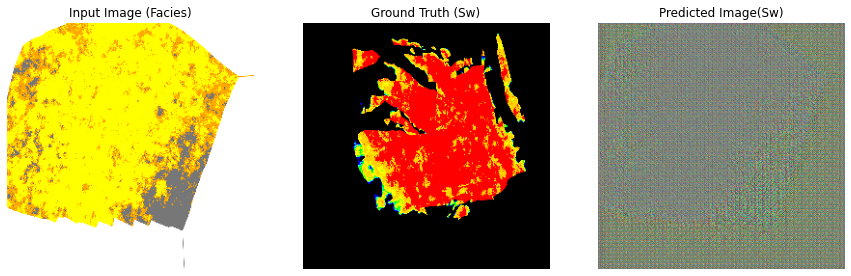

2025-01-02 00:32:13.346571: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

The training process involves generating outputs from the input images, calculating losses, updating gradients, and monitoring progress.

### Steps:
1. **Input and Output Generation:**
   - The discriminator receives two sets of inputs:
     - The `input_image` and the `generated_image` (from the generator).
     - The `input_image` and the `target_image` (ground truth).

2. **Loss Calculation:**
   - Compute generator loss (`gen_total_loss`, `gen_gan_loss`, and `gen_l1_loss`).
   - Compute discriminator loss (`disc_loss`).

3. **Gradient Updates:**
   - Calculate the gradients of the loss with respect to the generator and discriminator variables.
   - Apply the gradients using the optimizer.

4. **Logging:**
   - Log losses to TensorBoard for visualization and monitoring.

In [39]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

## Training Loop

### Steps:
1. **Iterate Through the Dataset:**
   - The training loop iterates over the dataset for a specified number of steps.

2. **Progress Monitoring:**
   - Every 10 steps, print a progress dot (`.`) to indicate that the training is running.

3. **Visualization:**
   - Every 1,000 steps:
     - Clear the display for a cleaner output.
     - Generate and display sample images using the generator's predictions.

4. **Checkpoint Saving:**
   - Every 5,000 steps, save a model checkpoint to allow resuming training or saving progress.


In [41]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

 **TensorBoard**:

    Use TensorBoard to monitor training progress and visualize logged metrics.
 **Monitoring**

1. **Balance Between Generator and Discriminator:**
   - Ensure that neither the generator nor the discriminator becomes dominant during training.

2. **Loss Values:**
   - Monitor the loss values for both the generator and discriminator to ensure they remain balanced.

3. **Improvement Tracking:**
   - Observe `gen_l1_loss` over time to confirm consistent improvements in the generator's performance.


In [42]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Reusing TensorBoard on port 6006 (pid 38730), started 2 days, 11:21:23 ago. (Use '!kill 38730' to kill it.)

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

Finally, run the training loop:

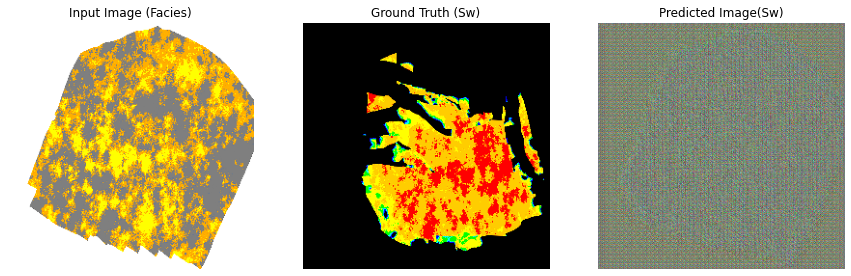

Step: 0k
....................................................................................................

2025-01-02 00:38:30.000786: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
fit(train_dataset, test_dataset, steps=1000)

## Interpreting the Logs

1. **Balance Between Generator and Discriminator:**
   - Ensure neither the generator nor the discriminator has "won." If `gen_gan_loss` or `disc_loss` becomes very low, it indicates one model is dominating, which hinders successful combined training.

2. **Reference Loss Values:**
   - A loss value of `log(2) = 0.69` serves as a reference point, indicating the discriminator is equally uncertain about real and generated images.

3. **Discriminator Performance:**
   - A `disc_loss` below `0.69` means the discriminator is performing better than random on distinguishing real and generated images.

4. **Generator Performance:**
   - A `gen_gan_loss` below `0.69` signifies the generator is effectively fooling the discriminator.

5. **Generator Improvement:**
   - As training progresses, monitor the `gen_l1_loss` to ensure it decreases over time, reflecting improved structural similarity between generated and target images.


## Restore the latest checkpoint and test the network

In [44]:
!ls {checkpoint_dir}

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


checkpoint		     ckpt-20.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-20.index
ckpt-10.index		     ckpt-21.data-00000-of-00001
ckpt-11.data-00000-of-00001  ckpt-21.index
ckpt-11.index		     ckpt-22.data-00000-of-00001
ckpt-12.data-00000-of-00001  ckpt-22.index
ckpt-12.index		     ckpt-2.data-00000-of-00001
ckpt-13.data-00000-of-00001  ckpt-2.index
ckpt-13.index		     ckpt-3.data-00000-of-00001
ckpt-14.data-00000-of-00001  ckpt-3.index
ckpt-14.index		     ckpt-4.data-00000-of-00001
ckpt-15.data-00000-of-00001  ckpt-4.index
ckpt-15.index		     ckpt-5.data-00000-of-00001
ckpt-16.data-00000-of-00001  ckpt-5.index
ckpt-16.index		     ckpt-6.data-00000-of-00001
ckpt-17.data-00000-of-00001  ckpt-6.index
ckpt-17.index		     ckpt-7.data-00000-of-00001
ckpt-18.data-00000-of-00001  ckpt-7.index
ckpt-18.index		     ckpt-8.data-00000-of-00001
ckpt-19.data-00000-of-00001  ckpt-8.index
ckpt-19.index		     ckpt-9.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-9.index
ckpt-1.index


In [45]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:


# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(363):
  generate_images(generator, inp, tar)
     


## Generate and Save Images from the Test Set

### Overview
- Use the trained generator to predict outputs for test set examples.
- Save high-resolution comparison images (Input, Ground Truth, Prediction) in a specified directory.

### Key Steps
1. **Test the Generator**:
   - Pass test set images through the generator.
   - Generate predictions and compare with ground truth.

2. **Save Results**:
   - Save side-by-side visualizations as `.png` files.

In [ ]:
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Define the save directory path
save_path = '/home/g202103050/Documents/A.Rahman/2-3D GAN part/2D/2D_New Eara/Facies to por or perm or Sw/results/100kSw_images'
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

# Modified generate_images function
def generate_and_save_images(generator, inp, tar, idx):
    prediction = generator(inp, training=True)
    
    # Convert TensorFlow tensors to NumPy arrays
    inp_img = inp[0].numpy() * 0.5 + 0.5  # Denormalize to [0,1]
    tar_img = tar[0].numpy() * 0.5 + 0.5  # Denormalize to [0,1]
    pred_img = prediction[0].numpy() * 0.5 + 0.5  # Denormalize to [0,1]

    # Set up matplotlib figure with larger dimensions for higher resolution
    plt.figure(figsize=(20, 8))  # Adjust size for better resolution
    
    display_list = [inp_img, tar_img, pred_img]
    title = ['Input Image (Facies)', 'Ground Truth (Sw)', 'Predicted Image(Sw)']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    
    # Save the figure with high DPI and tight bounding box
    plt.savefig(os.path.join(save_path, f"comparison_image_{idx+1}.png"), dpi=900, bbox_inches='tight', format='png')
    plt.close()

# Run the trained model on a few examples from the test set
for idx, (inp, tar) in enumerate(test_dataset.take(363)):
    generate_and_save_images(generator, inp, tar, idx)
    print(f"Saved high-resolution comparison image {idx+1} at {os.path.join(save_path, f'comparison_image_{idx+1}.png')}")


### Task 1: Mask Prediction

- **Masked Facies Example**  
  ![Masked Facies Example](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Examples%20of%20Results/Mask%20facies.png)

- **Masked SW Example**  
  ![Masked SW Example](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Examples%20of%20Results/Mask%20Sw.png)

---

### Task 2: Image-to-Image Translation

- **Facies to Porosity**  
  ![Facies to Porosity](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Examples%20of%20Results/Fc%20to%20Pors%20.png)

- **Porosity to Facies**  
  ![Porosity to Facies](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Examples%20of%20Results/Pors%20to%20FC.png)

- **Facies to Permeability**  
  ![Facies to Permeability](https://raw.githubusercontent.com/ARhaman/GeoPix/main/Examples%20of%20Results/FC%20to%20PERM%20.png)
